In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [2]:
# Load in data
data = pd.read_csv('../datasets/train_clean.csv')

In [3]:
pd.set_option('display.max_rows', 100)

In [4]:
# Remove Unnamed column
data.drop(['Unnamed: 0'], axis=1, inplace=True)

### Create New Numeric Features and Remove Old Ones
New features will be created by combining related features with high correlation to saleprice. Old features or features that seem reduntant will be removed

In [5]:
# Sum wooden_deck_sf, open_porch_sf and screen_porch into 'porch_sf' column, drop old columns
data['porch_sf'] = data['wood_deck_sf'] + data['open_porch_sf'] + data['screen_porch']
data.drop(columns=['open_porch_sf', 'wood_deck_sf', 'screen_porch'], inplace=True)

Text(0, 0.5, 'SalePrice in dollars')

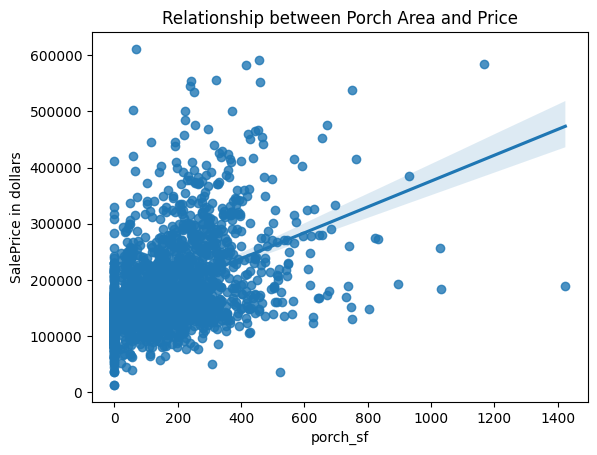

In [30]:
# scatterplot of porch area and price
sns.regplot(x=data['porch_sf'], y=data['saleprice']) 
plt.title('Relationship between Porch Area and Price')
plt.ylabel('SalePrice in dollars')

In [6]:
# Make new column 'house_remod_sold' from year_remod/add - yr_sold
data['house_remod_sold'] = data['yr_sold'] - data['year_remod/add']

In [7]:
# Make new column 'house_age_sold' from year_built - yr_sold, drop old columns
data['house_age_sold'] = data['yr_sold'] - data['year_built']
data.drop(columns=['year_built', 'yr_sold', 'year_remod/add'], inplace=True)

In [8]:
# remove basement 2 data due to very low correlation to price
# these columns seem already well represented by total_bsmt_sf
data.drop(columns=['bsmt_half_bath', 'bsmtfin_sf_2','bsmt_unf_sf'], inplace=True)

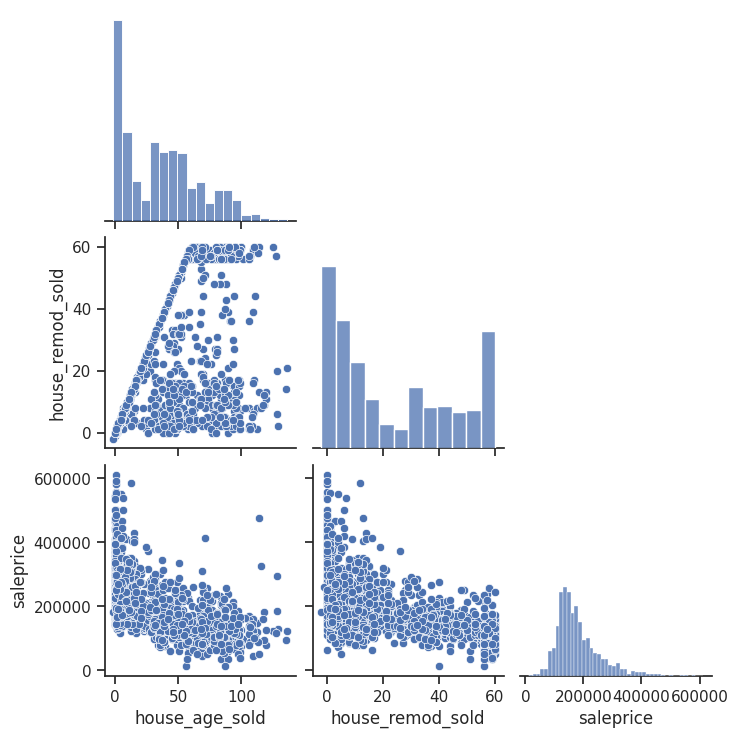

In [39]:
# house age and remodel agains saleprice
sns.set(style="ticks", color_codes=True)    
sns.pairplot(data[['house_age_sold','house_remod_sold','saleprice']], corner=True)
plt.show()

### Reduce number of features
This will be based on correlation with saleprice and interpretation of the feature from the data dictionary

In [9]:
# look at some correlations
numeric = ['int64', 'float64']
numeric_data = data.select_dtypes(include=numeric)
corr = numeric_data.corr()
corr[['saleprice']].sort_values(by='saleprice', ascending=False)

,saleprice
saleprice,1.000000
overall_qual,0.799758
gr_liv_area,0.696072
garage_area,0.646000
total_bsmt_sf,0.627687
1st_flr_sf,0.619904
full_bath,0.539696
totrms_abvgrd,0.501978
fireplaces,0.468253
porch_sf,0.456463


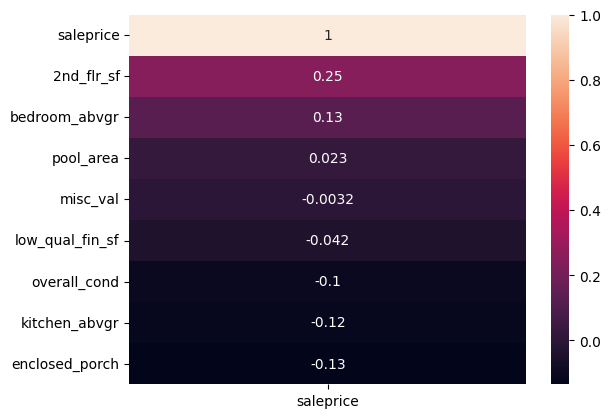

In [10]:
# take a look at some features with expected low relationship with saleprice
corr = data[['kitchen_abvgr', '2nd_flr_sf', 'low_qual_fin_sf', 'enclosed_porch', 'overall_cond', 'misc_val', 'pool_area', 'bedroom_abvgr', 'saleprice']].corr()
sns.heatmap(corr[['saleprice']].sort_values(by='saleprice', ascending=False), annot=True);

In [11]:
# The above features will be removed in order to reduce potential noice with the dataset
data.drop(columns = ['kitchen_abvgr', '2nd_flr_sf', 'low_qual_fin_sf', 'enclosed_porch', 'overall_cond', 'misc_val', 'pool_area', 'bedroom_abvgr'], inplace=True)

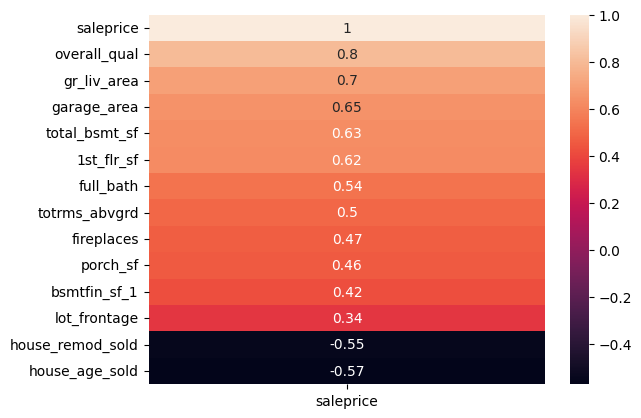

In [12]:
# look at numerical features with high correlation to saleprice
corr = data[['overall_qual', 'gr_liv_area', 'garage_area', 'total_bsmt_sf', '1st_flr_sf', 'house_age_sold', 'house_remod_sold', 'full_bath', 'totrms_abvgrd', 'fireplaces', 'porch_sf', 'bsmtfin_sf_1','lot_frontage', 'saleprice']].corr()
sns.heatmap(corr[['saleprice']].sort_values(by='saleprice', ascending=False), annot=True);

Numerical Features with a correlation higher that 0.3 with saleprice will be kept. All others will be dropped (excpet id which is needed for predictions)

In [13]:
# drop features with low correlation
data.drop(columns = ['lot_area', 'bsmt_full_bath', 'half_bath', '3ssn_porch', 'pid'], inplace=True)

### Visualize some categorical features

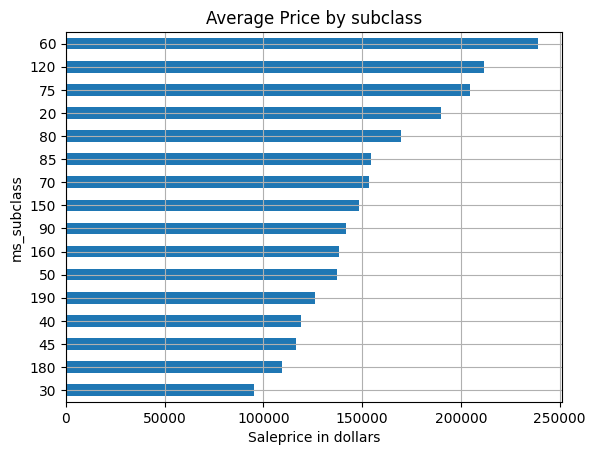

In [14]:
# visualize average sale price by subclass
sub_price = data.groupby('ms_subclass')['saleprice'].mean()
sub_price.sort_values(inplace=True)
plt.xlabel('Saleprice in dollars')
plt.grid()
sub_price.plot(grid=True, kind='barh', title='Average Price by subclass', yticks=list(range(0, 400000, 50000)));

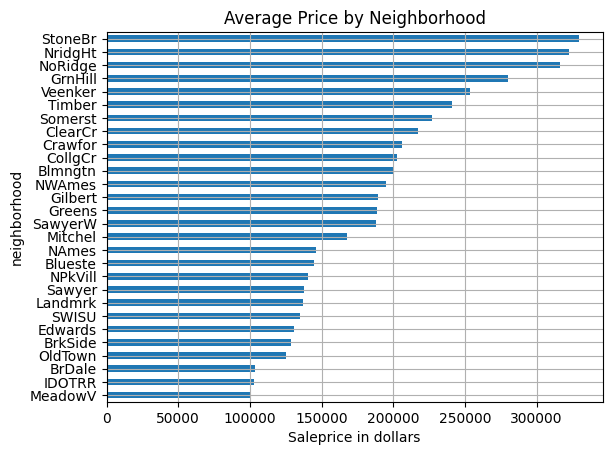

In [15]:
# visualize average sale price by neighborhood
hood_price = data.groupby('neighborhood')['saleprice'].mean()
hood_price.sort_values(inplace=True)
plt.xlabel('Saleprice in dollars')
plt.grid()
hood_price.plot(grid=True, kind='barh', title='Average Price by Neighborhood', yticks=list(range(0, 400000, 50000)));

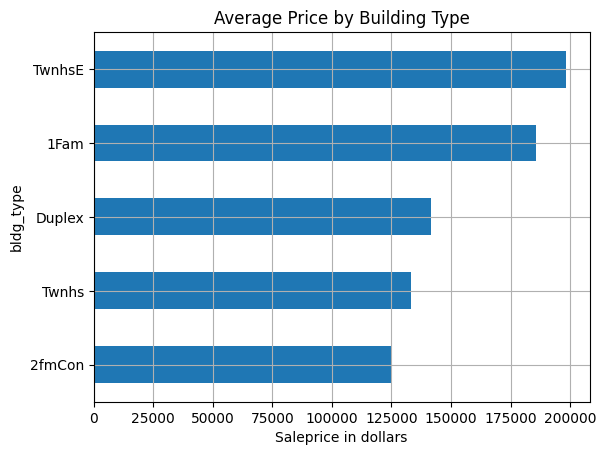

In [16]:
# visualize average sale price by building type
bldg_price = data.groupby('bldg_type')['saleprice'].mean()
bldg_price.sort_values(inplace=True)
plt.xlabel('Saleprice in dollars')
plt.grid()
bldg_price.plot(grid=True, kind='barh', title='Average Price by Building Type', yticks=list(range(0, 400000, 50000)));

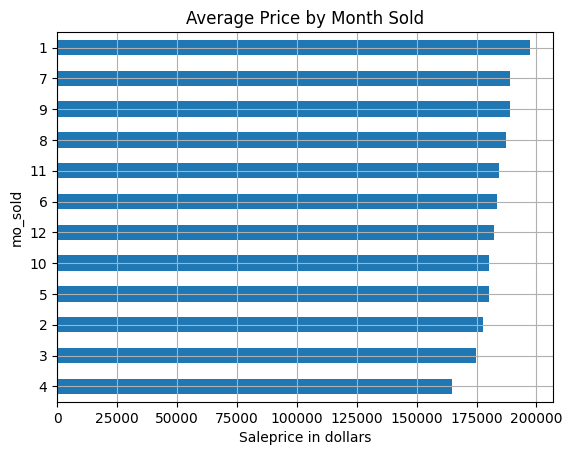

In [17]:
# visualize average sale price by month
mo_price = data.groupby('mo_sold')['saleprice'].mean()
mo_price.sort_values(inplace=True)
plt.xlabel('Saleprice in dollars')
plt.grid()
mo_price.plot(grid=True, kind='barh', title='Average Price by Month Sold', yticks=list(range(0, 400000, 50000)));

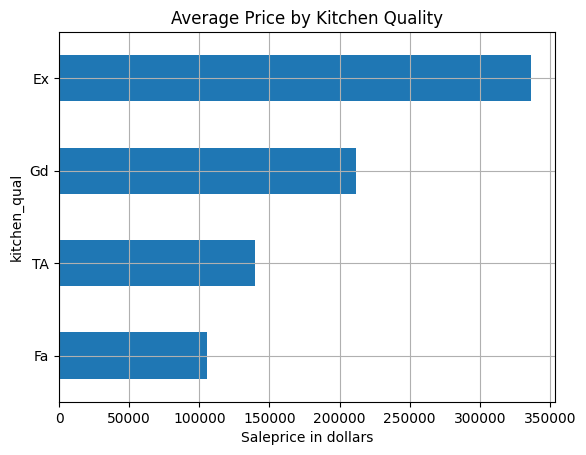

In [18]:
# visualize average sale price by kitchen quality
kch_price = data.groupby('kitchen_qual')['saleprice'].mean()
kch_price.sort_values(inplace=True)
plt.xlabel('Saleprice in dollars')
plt.grid()
kch_price.plot(grid=True, kind='barh', title='Average Price by Kitchen Quality', yticks=list(range(0, 400000, 50000)));

In [19]:
# drop mo_sold, ms_subclass and bldg_type due to low variation in saleprice by category
data.drop(columns=['bldg_type', 'mo_sold', 'ms_subclass'], inplace=True)

### One Hot Encoding
Neighborhood, kitchen_qual and bldg_type seem like good candidates for one hot encoding, since there are clear differences in average saleprice per category. bldg_type and kitchen_qual might be simpler since there are fewer categories, but both will be considered. mo_sold does not seem to greatly affect the saleprice and will not be used.

In [20]:
# One hot encode kitchen_qual and neighborhood (exterior_1st made it worse)
data = pd.get_dummies(columns = ['kitchen_qual', 'neighborhood'], data=data, drop_first=True)

In [21]:
# remove other categorical features for now. depending on model performance, others may be considered for ohe
data = data.select_dtypes(exclude=['object'])

In [22]:
data.head()

,id,lot_frontage,overall_qual,bsmtfin_sf_1,total_bsmt_sf,1st_flr_sf,gr_liv_area,full_bath,totrms_abvgrd,fireplaces,...,neighborhood_NoRidge,neighborhood_NridgHt,neighborhood_OldTown,neighborhood_SWISU,neighborhood_Sawyer,neighborhood_SawyerW,neighborhood_Somerst,neighborhood_StoneBr,neighborhood_Timber,neighborhood_Veenker
0,109,72.774648,6,533.0,725.0,725,1479,2,6,0,...,0,0,0,0,1,0,0,0,0,0
1,544,43.000000,7,637.0,913.0,913,2122,2,8,1,...,0,0,0,0,0,1,0,0,0,0
2,153,68.000000,5,731.0,1057.0,1057,1057,1,5,0,...,0,0,0,0,0,0,0,0,0,0
3,318,73.000000,5,0.0,384.0,744,1444,2,7,0,...,0,0,0,0,0,0,0,0,1,0
4,255,82.000000,6,0.0,676.0,831,1445,2,6,0,...,0,0,0,0,0,1,0,0,0,0


### Write feature engineered dataframe to csv
We now have a dataframe containing all columns we intend to use in our model. Create new csv to be used for model testing and validation

In [23]:
data.to_csv('../datasets/train_clean_fe.csv')